In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import datetime

In [ ]:
from google.colab import files
#uploaded = files.upload()

#Считываем файл
data = pd.read_csv("Consumo_cerveja.csv", skipfooter=576, engine='python')
#Убираем лишние строки
data = data.drop(data.index[data['Consumo de cerveja (litros)']=='Nan'])

#Сортируем по сезонам
def season(c):
    if int(c[5:7]) == 12 or int(c[5:7]) <= 2:
        return 'winter'
    elif 3 <= int(c[5:7]) <= 5:
       return 'spring'
    elif 6 <= int(c[5:7]) <= 8:
        return 'summer'
    return 'autumn'

#Сортируем по концу недели
def week_end(c):
    if str(c)=='0':
        return ('zero')
    return ('one')   

#Создаём новые более удобные столбцы
data['week'] = data.apply(lambda x: week_end(x['Final de Semana']), axis = 1)
data['season'] = data.apply(lambda x: season(x['Data']), axis = 1)
data['litro'] = data.apply(lambda x: float(x['Consumo de cerveja (litros)']),axis = 1)




---


# Гетероскедастичность
Гетероскедастичность — это свойство данных, используемых при построении регрессионной модели, когда разброс точек наблюдений вдоль линии регрессии является неравномерным на всем диапазоне изменения независимой переменной.
выражающийся в неодинаковой дисперсии случайной ошибки регрессионной модели. Наличие гетероскедастичности случайных ошибок приводит к неэффективности оценок, полученных с помощью метода наименьших квадратов.  Следовательно, статистические выводы о качестве полученных оценок могут быть неадекватными. В связи с этим тестирование моделей на гетероскедастичность является одной из необходимых процедур при построении регрессионных моделей.

Регрессия, устройчивая к гетерокседастичности создает результаты с устойчивой матрицей по умолчанию

In [ ]:
#Регрессия

#Регрессия устойчивая к гетероскедастичности
M=model = sm.OLS.from_formula('litro~ C(week)+ C(season)+ C(week):C(season)', data = data).fit().get_robustcov_results(cov_type='HC3')
M.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  litro   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     33.00
Date:                Tue, 31 May 2022   Prob (F-statistic):           2.71e-35
Time:                        08:44:03   Log-Likelihood:                -973.71
No. Observations:                 365   AIC:                             1963.
Df Residuals:                     357   BIC:                             1995.
Df Model:                           7                                         
Covariance Type:                  HC3                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              28.4687      0.914     31.136      0.000      26.671      30.267
C(week)[T.zero]                        -3.1172      1.056     -2.951      0.003      -5.194      -1.040
C(season)[T.spring]                    -0.3256      1.083     -0.301      0.764      -2.456       1.804
C(season)[T.summer]                     0.1157      1.191      0.097      0.923      -2.227       2.458
C(season)[T.winter]                     2.1199      1.166      1.817      0.070      -0.174       4.414
C(week)[T.zero]:C(season)[T.spring]    -2.5377      1.256     -2.021      0.044      -5.007      -0.069
C(week)[T.zero]:C(season)[T.summer]    -3.2164      1.361     -2.364      0.019      -5.892      -0.541
C(week)[T.zero]:C(season)[T.winter]    -1.5424      1.348     -1.144      0.253      -4.193       1.108
==============================================================================
Omnibus:                        0.460   Durbin-Watson:                   1.338
Prob(Omnibus):                  0.794   Jarque-Bera (JB):                0.574
Skew:                           0.068   Prob(JB):                        0.751
Kurtosis:                       2.861   Cond. No.                         16.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

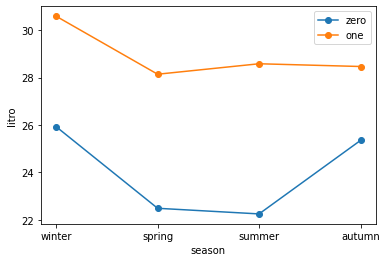

In [ ]:
#Рисуем графики
means = np.zeros((2,4))
for i,week in enumerate(['zero','one']):
    for j,season in enumerate(['winter','spring','summer','autumn']):
    
        means[i,j] = data[(data['week']==week)&(data['season']==season)]['litro'].mean()
        #print(week,season,means[i,j])


for i,week in enumerate(['zero','one']):

    plt.plot(means[i],label=week,marker='o')

plt.xticks([0,1,2,3],['winter','spring','summer','autumn'])
plt.xlabel('season')
plt.ylabel('litro')
plt.legend()
plt.show()

In [ ]:
#Гипотеза
aov_table = anova_lm(M, typ=2, robust = 'hc3')
print(aov_table)

print("---------------------------------------------------------------")
def h0(c, i):
  if float(aov_table.loc[c][3]) <= alpha and i == 1:
    print("Фактор %s отвергаем - Влияние фактора значимое"%(c[1:]))
  elif float(aov_table.loc[c][3]) > alpha and i == 1:
    print("Фактор %s принимаем - Влияния фактора нет"%(c[1:]))
  elif float(aov_table.loc[c][3]) <= alpha:
    print("Фактор %s отвергаем - Факторы взаимодействуют"%(c[1:]))
  elif float(aov_table.loc[c][3]) > alpha:
    print("Фактор %s принимаем - Факторы влияют аддитивно"%(c[1:]))
for alpha in [0.05, 0.1]:
  print("alpha = %.2f"%alpha)
  h0('C(week)', 1)
  h0('C(season)', 1)
  h0('C(week):C(season)', 2)
  print()


                        sum_sq     df           F        PR(>F)
C(week)            1951.853257    1.0  157.095581  4.073617e-30
C(season)           802.379023    3.0   21.526584  7.737050e-13
C(week):C(season)    80.756601    3.0    2.166574  9.164490e-02
Residual           4435.590151  357.0         NaN           NaN
---------------------------------------------------------------
alpha = 0.05
Фактор (week) отвергаем - Влияние фактора значимое
Фактор (season) отвергаем - Влияние фактора значимое
Фактор (week):C(season) принимаем - Факторы влияют аддитивно

alpha = 0.10
Фактор (week) отвергаем - Влияние фактора значимое
Фактор (season) отвергаем - Влияние фактора значимое
Фактор (week):C(season) отвергаем - Факторы взаимодействуют



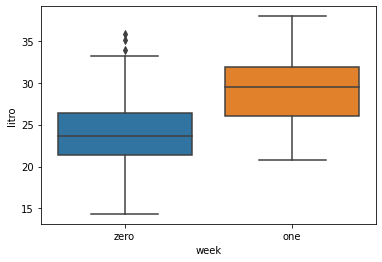

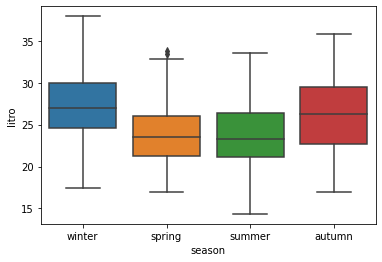

In [ ]:
#Еще графики
sns.boxplot( y=data['litro'], x=data['week'] );
plt.show()
sns.boxplot( y=data['litro'], x=data['season'] );
plt.show()